# Example: Woods Hole temperature variability

In [28]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import cmocean
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import scipy.signal
import copy

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## Functions

In [39]:
def plot_setup(fig, projection, lon_range, lat_range, xticks=None, yticks=None):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    ## add tick labels
    if xticks is not None:

        ## add lon/lat labels
        gl = ax.gridlines(
            draw_labels=True,
            linestyle="-",
            alpha=0.1,
            linewidth=0.5,
            color="k",
            zorder=1.05,
        )

        ## specify which axes to label
        gl.top_labels = False
        gl.right_labels = False

        ## specify ticks
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xlocator = mticker.FixedLocator(xticks)

    return ax


def plot_box_outline(ax, lon_range, lat_range):
    """
    Plot box outlining the specifed lon/lat range on given
    ax object.
    """

    ## get width and height
    height = lat_range[1] - lat_range[0]
    width = lon_range[1] - lon_range[0]

    ## add rectangle to plot
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lon_range[0], lat_range[0]],
            height=height,
            width=width,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor="k",
            linewidth=1,
        )
    )

    return ax


def plot_correlation(plot_setup_fn, corr, x, y):
    """
    Make spatial plot of correlation, using the specified
    plot setup function and pre-computed correlation.
    Args:
        - plot_setup_fn: function that returns a fig, ax object
        - corr: xarray with spatial correlation
        - x, y: lon/lat points for plotting
    """

    ## blank canvas to plot on
    fig = plt.figure()

    ## draw background map of Atlantic
    fig, ax = plot_setup_fn(fig)

    ## plot the data
    plot_data = ax.contourf(
        x,
        y,
        corr,
        transform=ccrs.PlateCarree(),
        levels=make_cb_range(1, 0.1),
        extend="both",
        cmap="cmo.balance",
    )

    ## create colorbath
    colorbar = fig.colorbar(plot_data, label="Corr.", ticks=[-1, -0.5, 0, 0.5, 1])

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def plot_setup_timeseries():
    """
    Create fig, ax objects and label time axis
    """

    ## set up plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## restrict to last 50 years and label axes
    ax.set_xlim([datetime.date(1970, 1, 1), None])

    ax.set_xticks(
        [
            datetime.date(1979, 1, 1),
            datetime.date(2000, 6, 30),
            datetime.date(2021, 12, 31),
        ]
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    return fig, ax


def plot_seasonal_cycle(mean, std):
    """
    Plot the seasonal cycle (monthly mean ± 1 standard dev.)
    """

    ## plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## mean
    ax.plot(np.arange(1, 13), mean, c="k", label=r"$\mu$")

    ## mean ± std
    ax.plot(np.arange(1, 13), mean + std, c="k", lw=0.5, label=r"$\mu \pm \sigma$")
    ax.plot(np.arange(1, 13), mean - std, c="k", lw=0.5)

    ## label

    ax.legend()

    return fig, ax


def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.latitude)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["longitude", "latitude"])

    return avg


def get_trend(data, dim="time", deg=1):
    """
    Get trend for an xr.dataarray along specified dimension,
    by fitting polynomial of degree 'deg'.
    """

    ## Get coefficients for best fit
    polyfit_coefs = data.polyfit(dim=dim, deg=deg)["polyfit_coefficients"]

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend


def detrend(data, dim="time", deg=1):
    """
    Remove trend of degree 'deg' from data, along dimension 'dim'.
    """

    return data - get_trend(data, dim=dim, deg=deg)


def get_empirical_pdf(x):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    hist, bin_edges = np.histogram(x)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges


def get_gaussian_best_fit(x):
    """Get gaussian best fit to data, and evaluate
    probabilities over the range of the data."""

    ## get normal distribution best fit
    gaussian = scipy.stats.norm(loc=x.mean(), scale=x.std())

    ## evaluate over range of data
    amp = np.max(np.abs(x.values))
    x_eval = np.linspace(-amp, amp)
    pdf_eval = gaussian.pdf(x_eval)

    return pdf_eval, x_eval


def swap_longitude_range(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180]"""

    ## copy of longitude coordinate to be modified
    new_longitude = copy.deepcopy(data.longitude.values)

    ## find index where longitude first exceeds 180.
    ## (note: np.argmax returns first instance of "True" in boolean array)
    swap_idx = np.argmax(new_longitude > 180)

    ## relabel values >180
    new_longitude[swap_idx:] = -360 + new_longitude[swap_idx:]

    ## add this coordinate back to the array
    data["longitude"] = new_longitude

    ## "roll" the data to be centered at zero
    data = data.roll({"longitude": -swap_idx}, roll_coords=True)

    return data

### Region-specific functions

In [44]:
def trim_to_north_atl(data):
    """trim xr.DataArray to North Atlantic region"""

    ## boolean arrays for lon/lat
    lon_in_range = (data.longitude >= -100) & (data.longitude <= 15)
    lat_in_range = (data.latitude >= 0) & (data.latitude <= 70)

    return data.isel(latitude=lat_in_range, longitude=lon_in_range)


def plot_setup_atlantic(fig):
    """Plot Atlantic region"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## specify map projection
    proj = ccrs.Orthographic(central_longitude=-50, central_latitude=40)

    ## get ax object
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-100, 0],
        lat_range=[10, 70],
        xticks=[-90, -45, 0],
        yticks=[0, 35],
    )

    return fig, ax


def plot_setup_woodshole(fig):
    """Plot zoomed-in view of Woods Hole"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## set map projection to orthographic
    proj = ccrs.Orthographic(central_longitude=-67.5, central_latitude=40)

    ## Get ax object based on generic plotting function
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-75, -60],
        lat_range=[35, 45],
        xticks=[-73, -68, -63],
        yticks=[37, 42],
    )

    return fig, ax

## Loading and plotting the data

### Load the data

In [4]:
## Path to file server
server_fp = pathlib.Path("/Volumes")

## Filepath to the ERA5 reanalysis
era5_fp = pathlib.Path("cmip6/data/era5/reanalysis/single-levels/monthly-means")

## sea surface temperature (SST) filepaths
era5_fp_sst = server_fp / era5_fp / pathlib.Path("sea_surface_temperature")

## open the data
data = xr.open_mfdataset(era5_fp_sst.glob("*.nc"))["sst"]

### Pre-processing
1. Swap longitude range from [0,360) to (-180,180] to make plotting easier
2. Trim data to a smaller region to make computations faster
3. Load into memory

In [5]:
## swap longitude_range
data = swap_longitude_range(data)

## trim to North Atlantic
data = trim_to_north_atl(data)

## load into memory
data = data.compute()

### Plot a sample from the data

```{admonition} To-do
Label this!
```

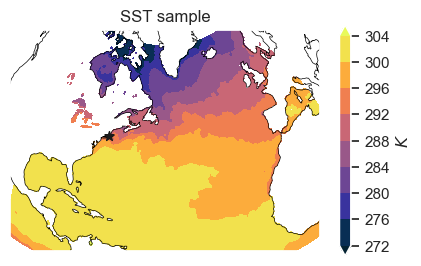

In [47]:
## blank canvas to plot on
fig = plt.figure()

## draw background map of Atlantic
fig, ax = plot_setup_atlantic(fig)

## plot the data
plot_data = ax.contourf(
    data.longitude,
    data.latitude,
    data.isel(time=-1),
    transform=ccrs.PlateCarree(),
    levels=10,
    extend="both",
    cmap="cmo.thermal",
)

## create colorbath
colorbar = fig.colorbar(plot_data, label=r"$K$")

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="k", s=50, zorder=10
)

## label
ax.set_title(f"SST sample")

plt.show()

## Define an index
Next, let's define the "Woods Hole temperature index", $T_{wh}$ as the temperature averaged near Woods Hole.

In [42]:
## define outline of area for computing the index
T_WH_LON_RANGE = [-72.5, -66.5]
T_WH_LAT_RANGE = [39, 44]


## a function to compute the index
def compute_T_wh(x):
    """Compute Woods Hole temperature index"""

    ## get subset of data inside the box
    ## the '[::-1]' is needed because latitude is
    ## in descending order in this dataset.
    data_subset = x.sel(
        latitude=slice(*T_WH_LAT_RANGE[::-1]), longitude=slice(*T_WH_LON_RANGE)
    )

    ## compute spatial average
    return spatial_avg(data_subset)


## do the computation here
idx = compute_T_wh(data)

Let's plot an outline of the region below:

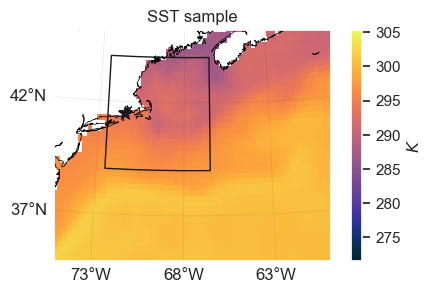

In [46]:
## blank canvas to plot on
fig = plt.figure()

## draw background map of Atlantic
fig, ax = plot_setup_woodshole(fig)

## plot the data
xx, yy = np.meshgrid(data.longitude.values, data.latitude.values)
plot_data = ax.pcolormesh(
    xx,
    yy,
    data.isel(time=-1),
    transform=ccrs.PlateCarree(),
    cmap="cmo.thermal",
)

## create colorbar
colorbar = fig.colorbar(plot_data, label=r"$K$")

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="k", s=100, zorder=10
)

## plot outline of region used to compute index
ax = plot_box_outline(ax, lon_range=T_WH_LON_RANGE, lat_range=T_WH_LAT_RANGE)

## label the plot
ax.set_title(f"SST sample")

plt.show()

In [ ]:
fig, ax = plot_setup_timeseries()

## Plot the data
ax.plot(idx.time, idx)

## label axes
ax.set_title(r"Woods Hole temperature index")
ax.set_ylabel(r"$K$")

plt.show()

## Diagnostics

### Seasonal cycle

In [ ]:
## compute mean and standard deviation
seasonal_mean = idx.groupby("time.month").mean("time")
seasonal_std = idx.groupby("time.month").std("time")

## make the plot
fig, ax = plot_seasonal_cycle(seasonal_mean, seasonal_std)

## add some labels
ax.set_xticks([1, 3, 8, 12], labels=["Jan", "Mar", "Aug", "Dec"])
ax.set_title(r"$T_{wh}$ climatology")
ax.set_ylabel(r"$K$")

plt.show()

### Compute anomalies and linear trend for index

In [ ]:
## compute anomalies at gridpoint level, then recompute temperature index
data_anom = data.groupby("time.month") - data.groupby("time.month").mean()
idx_anom = compute_T_wh(data_anom).compute()

## compute linear trend (set deg=2 for quadratic trend)
idx_trend = get_trend(idx_anom, deg=1)

### Next, let's plot the anomalies

In [ ]:
## setup the plot
fig, ax = plot_setup_timeseries()

## plot index
ax.plot(idx_anom.time, idx_anom)

## superimpose trend
ax.plot(idx_trend.time, idx_trend, label="trend", c="k")
ax.legend()

## label plot
ax.set_title(r"$T_{wh}$ anomalies")
ax.set_ylabel(r"$K$")

plt.show()

### Histogram

In [ ]:
## compute normalized histogram and best-fit Gaussian
pdf, pdf_edges = get_empirical_pdf(idx_anom)
pdf_gauss, pdf_gauss_pts = get_gaussian_best_fit(idx_anom)

#### Plot result
fig, ax = plt.subplots(figsize=(4, 3))

## plot histogram
ax.stairs(values=pdf, edges=pdf_edges)

## plot gaussian
x = np.linspace(-3, 3)
ax.plot(pdf_gauss_pts, pdf_gauss, c="k")

## label
ax.set_xlabel(r"$K$ anomaly")
ax.set_ylabel("Probability")

plt.show()

#### Power spectral density (PSD)

In [ ]:
## compute PSD
## 'fs' is sampling frequency (units: samples/year)
freq, psd = scipy.signal.welch(idx_anom.values, fs=12)

## plot result
fig, ax = plt.subplots(figsize=(4, 3))
ax.loglog(freq, psd)
ax.set_xlabel("Freq (1/year)")
ax.set_ylabel(r"PSD (variance $\cdot$ year)")
plt.show()

### Spatial correlation
(between index and spatial data)

In [ ]:
## compute correlation (detrend data first)
corr = xr.corr(detrend(data_anom), detrend(idx_anom), dim="time")

## Make plot
fig, ax = plot_correlation(
    plot_setup_fn=plot_setup_atlantic, corr=corr, x=corr.longitude, y=corr.latitude
)

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="magenta", s=50, zorder=10
)

## label
ax.set_title(r"Correlation with $T_{wh}$")

plt.show()